In [1]:
from fastai.tabular import * 

In [2]:
dPath = Path("../docs/dumps")

In [3]:
with open(dPath / "train_data.pkl", 'rb') as filename:
    train_data = pickle.load(filename)

In [4]:
with open(dPath / "valid_data.pkl", 'rb') as filename:
    valid_data = pickle.load(filename)

In [5]:
with open(dPath / "test_data.pkl", 'rb') as filename:
    test_data = pickle.load(filename)

In [6]:
with open(dPath / "not_running.pkl", 'rb') as filename:
    not_running = pickle.load(filename)

In [7]:
with open(dPath / "rf_exp_05_names.pkl", 'rb') as filename:
    names = pickle.load(filename)

In [8]:
with open(dPath / "mutclslabels.pkl", 'rb') as filename:
    mutclslabels = pickle.load(filename)

with open(dPath / "retypelabels.pkl", 'rb') as filename:
    retypelabels = pickle.load(filename)

mutclscodes = dict(zip(mutclslabels,range(len(mutclslabels))))

retypecodes = dict(zip(retypelabels,range(len(retypelabels))))

In [9]:
test_data.replace(mutclscodes, inplace=True)
test_data.replace(retypecodes, inplace=True)

In [ ]:
test_data['MutatorClass'] = test_data.MutatorClass.astype('category')
test_data['returnType'] = test_data.returnType.astype('category')

In [10]:
len(valid_data)

67496

In [16]:
from imblearn.over_sampling import ADASYN

In [17]:
sm = ADASYN(random_state=42, n_jobs=-1,  n_neighbors=5)

In [18]:
X_train = train_data.drop("Detected", axis=1)
y_train = train_data.Detected

In [19]:
%time X_train, y_train = sm.fit_resample(X_train, y_train)

Wall time: 2min 31s


In [21]:
train_data = pd.concat([X_train, y_train], axis=1)

In [23]:
all_df = pd.concat([train_data, not_running, valid_data],axis=0,ignore_index=True)

In [24]:
all_df['MutatorClass'] = all_df.MutatorClass.astype('category')

In [25]:
all_df['returnType'] = all_df.returnType.astype('category')

In [26]:
all_df.head().T.head(40)

,0,1,2,3,4
MutatorClass,2,6,6,0,0
returnType,3,3,3,3,3
numExecuted,14,14,14,14,14
numTestCover,1,1,1,1,1
numAssertInTM,7,7,7,7,7
numAssertInTC,14,14,14,14,14
ppnumberOfClasses,5,5,5,5,5
ppnumberOfStatements,232,232,232,232,232
ppavcc,2.125,2.125,2.125,2.125,2.125
pphalsteadCumulativeBugs,2.63609,2.63609,2.63609,2.63609,2.63609


In [27]:
all_df = all_df[list(names) + ['Detected']]
test_data = test_data[list(names) + ['Detected']]

In [30]:
procs = [Categorify, Normalize]

In [31]:
valid_idx = range(len(all_df) - len(valid_data), len(all_df))

In [32]:
dep_var = 'Detected'
cat_names = ['MutatorClass', 'returnType']

In [33]:
data = TabularDataBunch.from_df(dPath, all_df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names,test_df=test_data)

In [38]:
learn = tabular_learner(data, layers=[200,100], emb_szs={'MutatorClass': 8, 'returnType': 10}, metrics=[accuracy,Precision(),Recall(),MatthewsCorreff(),AUROC(), FBeta(beta=1)])

In [39]:
learn.summary()

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [8]                  144        True      
______________________________________________________________________
Embedding            [10]                 220        True      
______________________________________________________________________
Dropout              [18]                 0          False     
______________________________________________________________________
BatchNorm1d          [36]                 72         True      
______________________________________________________________________
Linear               [200]                11,000     True      
______________________________________________________________________
ReLU                 [200]                0          False     
______________________________________________________________________
BatchNorm1d          [200]                400        True      
_________________________________________________

In [40]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,precision,recall,matthews_correff,auroc,f_beta,time
0,0.584280,0.638560,0.639371,0.798643,0.696926,0.145920,0.613571,0.744325,08:43
1,0.557708,0.641039,0.641149,0.798221,0.700702,0.145827,0.606582,0.746289,09:30
2,0.541466,0.662126,0.610851,0.804039,0.639116,0.143990,0.602979,0.712153,09:33


In [41]:
learn.show_results(5)

MutatorClass,returnType,mmvariablesReferenced,mmhalsteadEffort,pploc,numExecuted,ccmaintainabilityIndexNC,mmexternalMethodsCalled,pptcc,ppfanin,mminstanceVariablesReferenced,ppmaintainabilityIndex,numAssertInTM,numTestCover,ppabstractness,ccexternalMethodCalls,numAssertInTC,ppnumberOfStatements,ppfanout,cchalsteadCumulativeVolume,cchalsteadEffort,ppnumberOfClasses,ccmaintainabilityIndex,ccunweightedClassSize,ppdistance,ccnumberOfStatements,ppnumberOfMethods,ppmaxcc,mmnumberOfExpressions,ppRVF,ccfanIn,mmhalsteadVocabulary,mmhalsteadDifficulty,ppinstability,ppmaintainabilityIndexNC,ppavcc,cchalsteadCumulativeBugs,ccimportedPackages,target,prediction
2,3.0,-0.4481,-0.1296,-0.5070,-0.0365,-0.1725,-0.2879,-0.5199,-0.4919,-0.2584,-0.2045,-0.0607,-0.2274,-0.8997,-0.6239,-0.0696,-0.5039,-0.6352,-0.4287,-0.1489,-0.5214,-0.9177,-0.5355,-0.4136,-0.4719,-0.5354,-0.5419,-0.2230,-0.6411,-0.2805,-0.4697,-0.2805,1.0579,-0.5466,-0.1185,-0.4287,-0.6506,True,True
6,3.0,-0.4481,-0.1296,-0.5070,-0.0365,-0.1725,-0.2879,-0.5199,-0.4919,-0.2584,-0.2045,-0.0607,-0.2274,-0.8997,-0.6239,-0.0696,-0.5039,-0.6352,-0.4287,-0.1489,-0.5214,-0.9177,-0.5355,-0.4136,-0.4719,-0.5354,-0.5419,-0.2230,-0.6411,-0.2805,-0.4697,-0.2805,1.0579,-0.5466,-0.1185,-0.4287,-0.6506,True,True
6,3.0,-0.4481,-0.1296,-0.5070,-0.0365,-0.1725,-0.2879,-0.5199,-0.4919,-0.2584,-0.2045,-0.0607,-0.2274,-0.8997,-0.6239,-0.0696,-0.5039,-0.6352,-0.4287,-0.1489,-0.5214,-0.9177,-0.5355,-0.4136,-0.4719,-0.5354,-0.5419,-0.2230,-0.6411,-0.2805,-0.4697,-0.2805,1.0579,-0.5466,-0.1185,-0.4287,-0.6506,True,True
0,3.0,-0.4481,-0.1296,-0.5070,-0.0365,-0.1725,-0.2879,-0.5199,-0.4919,-0.2584,-0.2045,-0.0607,-0.2274,-0.8997,-0.6239,-0.0696,-0.5039,-0.6352,-0.4287,-0.1489,-0.5214,-0.9177,-0.5355,-0.4136,-0.4719,-0.5354,-0.5419,-0.2230,-0.6411,-0.2805,-0.4697,-0.2805,1.0579,-0.5466,-0.1185,-0.4287,-0.6506,True,True
0,3.0,-0.4481,-0.1296,-0.5070,-0.0365,-0.1725,-0.2879,-0.5199,-0.4919,-0.2584,-0.2045,-0.0607,-0.2274,-0.8997,-0.6239,-0.0696,-0.5039,-0.6352,-0.4287,-0.1489,-0.5214,-0.9177,-0.5355,-0.4136,-0.4719,-0.5354,-0.5419,-0.2230,-0.6411,-0.2805,-0.4697,-0.2805,1.0579,-0.5466,-0.1185,-0.4287,-0.6506,True,True


In [53]:
interp = ClassificationInterpretation.from_learner(learn)

In [54]:
interp.confusion_matrix()

array([[ 6845,  9812],
       [13340, 37499]], dtype=int64)

In [55]:
interp.most_confused()

[(True, False, 13340), (False, True, 9812)]

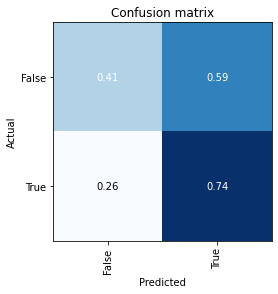

In [56]:
interp.plot_confusion_matrix(normalize=True)

In [46]:
learn.save('fastai_exp_5')
learn.load('fastai_exp_5')

Learner(data=TabularDataBunch;

Train: LabelList (1429113 items)
x: TabularList
MutatorClass 2; returnType 3.0; mmvariablesReferenced -0.4481; mmhalsteadEffort -0.1296; pploc -0.5070; numExecuted -0.0365; ccmaintainabilityIndexNC -0.1725; mmexternalMethodsCalled -0.2879; pptcc -0.5199; ppfanin -0.4919; mminstanceVariablesReferenced -0.2584; ppmaintainabilityIndex -0.2045; numAssertInTM -0.0607; numTestCover -0.2274; ppabstractness -0.8997; ccexternalMethodCalls -0.6239; numAssertInTC -0.0696; ppnumberOfStatements -0.5039; ppfanout -0.6352; cchalsteadCumulativeVolume -0.4287; cchalsteadEffort -0.1489; ppnumberOfClasses -0.5214; ccmaintainabilityIndex -0.9177; ccunweightedClassSize -0.5355; ppdistance -0.4136; ccnumberOfStatements -0.4719; ppnumberOfMethods -0.5354; ppmaxcc -0.5419; mmnumberOfExpressions -0.2230; ppRVF -0.6411; ccfanIn -0.2805; mmhalsteadVocabulary -0.4697; mmhalsteadDifficulty -0.2805; ppinstability 1.0579; ppmaintainabilityIndexNC -0.5466; ppavcc -0.1185; cchalsteadCum

In [47]:
learn.unfreeze()

In [48]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision,recall,matthews_correff,auroc,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


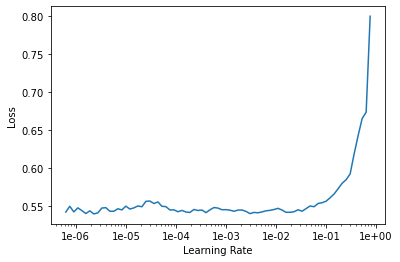

In [49]:
learn.recorder.plot()

In [34]:
doc(learn.fit_one_cycle)

In [50]:
learn.load('fastai_exp_5')
learn.unfreeze()

In [51]:
lr = 1e-2

In [52]:
learn.fit_one_cycle(1,slice(lr))

epoch,train_loss,valid_loss,accuracy,precision,recall,matthews_correff,auroc,f_beta,time
0,0.565547,0.620186,0.656987,0.792606,0.737603,0.139878,0.615886,0.764116,09:14


In [57]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)
result = preds.numpy()[:, 0]

In [65]:
len(preds), preds

(58476,
 tensor([[0.5999, 0.4001],
         [0.3871, 0.6129],
         [0.3229, 0.6771],
         ...,
         [0.6018, 0.3982],
         [0.3312, 0.6688],
         [0.3572, 0.6428]]))

In [61]:
np.histogram(preds)

(array([  399,  3019, 10898, 18911, 25249, 25249, 18911, 10898,  3019,   399], dtype=int64),
 array([0.017446, 0.113957, 0.210468, 0.306979, 0.403489, 0.5     , 0.596511, 0.693021, 0.789532, 0.886043, 0.982554],
       dtype=float32))

In [66]:
test_data.Detected

0        False
1         True
2         True
3         True
4         True
         ...  
58471    False
58472    False
58473    False
58474    False
58475    False
Name: Detected, Length: 58476, dtype: bool

In [106]:
from sklearn.metrics import average_precision_score, precision_score, recall_score
print(average_precision_score(test_data.Detected, preds[:,1] >= 0.5, average='micro'))

0.6954860849169364


In [104]:
from sklearn import metrics
metrics.roc_auc_score(test_data.Detected, preds[:,1] >= 0.5)

0.5958154402844242

In [103]:
from sklearn.metrics import classification_report
print(classification_report(test_data.Detected, preds[:,1] >= 0.5))

              precision    recall  f1-score   support

       False       0.48      0.48      0.48     20633
        True       0.71      0.71      0.71     37843

    accuracy                           0.63     58476
   macro avg       0.60      0.60      0.60     58476
weighted avg       0.63      0.63      0.63     58476



In [100]:
with open(dPath / "fastai_exp_5.pkl", 'wb') as filename:
    pickle.dump(preds,filename)

In [107]:
np.histogram(preds[:,1])

(array([    8,   264,  2210,  7068, 11811, 13225, 12213,  8602,  2707,   368], dtype=int64),
 array([0.029793, 0.125069, 0.220345, 0.315621, 0.410897, 0.506173, 0.601449, 0.696725, 0.792002, 0.887278, 0.982554],
       dtype=float32))